# PCC Matrix-Based Network

This notebook constructs a network using the Pearson Correlation Coefficient (PCC) matrix from the `energy_matrix_by_row.csv` file.

## Workflow:
1. **Load the Energy Matrix**: Read the file and compute the PCC matrix.
2. **Create the Network**: Nodes represent RNA sequences, and edges show correlations based on the PCC values.
3. **Filter and Visualize**: Apply a PCC threshold to keep strong correlations and visualize the network using a spring-embedded layout.

Ensure the CSV file is in `./data/csv/` before running the analysis.

In [24]:
# General library imports

import math
import random
from collections import Counter
from contextlib import suppress
from functools import partial, reduce

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns


In [21]:
# General graphing functions

def rm_nodes_below_minimum_edge_count(corr_df, min_edges=1, show_distribution=False):
    """Removes nodes from a DataFrame if they have fewer edges than a specified minimum threshold and provides an option
    to visualize the distribution of edge counts per node when requested.

    The function computes the edge counts for each node and retains nodes that meet or exceed the minimum edge count
    specified by 'min_edges'. Nodes that do not meet this threshold are removed from the DataFrame.

    If 'show_distribution' is set to True, a histogram displaying the distribution of edge counts per node will be shown.
    """
    query_nodes = Counter(corr_df["seq1"])
    array_nodes = Counter(corr_df["seq2"])
    # Gets accumulation of all nodes on both sides of the node
    sum_nodes = {k: int((v + array_nodes[k]) / 2) for k, v in query_nodes.items()}
    keep_nodes = [k for k, v in sum_nodes.items() if v >= min_edges]
    # Graph distribution for user if flagged
    if show_distribution is True:
        plt.hist(list(filter(lambda x: x > min_edges, sum_nodes.values())), bins=100)
        plt.title("Distribution of edge counts per node")
        plt.show()
    return corr_df[(corr_df["seq1"].isin(keep_nodes)) | (corr_df["seq2"].isin(keep_nodes))]


def build_graph(corr_df, source_node_idx, target_node_idx, edge_weight_idx):
    """Build a graph from a DataFrame representing connections between nodes and their edge weights.

    This function constructs a graph (NetworkX Graph) from a DataFrame that represents connections between nodes
    and their associated edge weights. The graph is built based on the specified indices for source nodes, target nodes,
    and edge weights.
    """
    G = nx.Graph()
    for arr in corr_df.to_numpy():
        G.add_node(arr[source_node_idx])
        G.add_node(arr[target_node_idx])
        w = arr[edge_weight_idx]
        G.add_edge(arr[source_node_idx], arr[target_node_idx], weight=w)
    G.remove_nodes_from(list(nx.isolates(G)))
    return G


def generate_circle_pos(stepsize=0.0001):
    """Generate positions of vertices to create a circular pattern.

    This function generates the positions of vertices to create a circular pattern. It starts from the
    center point and moves around the circle in small steps, adding each position to the list.
    """
    # The lower the stepsize value the higher quality the circle is with more points generated
    # Generated vertices
    t = 0
    circle_pos = []
    while t < 2 * math.pi:
        circle_pos.append((2000 * math.cos(t) + 3000, 2000 * math.sin(t) + 3000))
        t += stepsize

    return circle_pos


def remove_min_max_x_y_nodes(
    G,
    positions_dict,
    rm_min_y=False,
    num_min_y_to_remove=1,
    rm_max_y=False,
    num_max_y_to_remove=1,
    rm_min_x=False,
    num_min_x_to_remove=1,
    rm_max_x=False,
    num_max_x_to_remove=1,
):
    """Remove minimum and maximum X and Y coordinate nodes from a graph.

    This function creates a modified copy of the input graph (G) by removing nodes with minimum and maximum X and Y
    coordinates based on specified removal criteria. It also provides the option to retain a dictionary of
    positions that correspond to the removed nodes.
    """
    # Copying graph is imperative - it will change by reference
    G_copy = G.copy()
    x, y = zip(*tuple(positions_dict.values()))
    x_dict = {v[0]: k for k, v in positions_dict.items()}
    y_dict = {v[1]: k for k, v in positions_dict.items()}
    if rm_min_y is True:
        for i in range(num_min_y_to_remove):
            with suppress(KeyError):
                G_copy.remove_node(y_dict.pop(sorted(y)[i]))
    if rm_max_y is True:
        for i in range(num_max_y_to_remove):
            with suppress(KeyError):
                G_copy.remove_node(y_dict.pop(sorted(y)[-i]))
    if rm_min_x is True:
        for i in range(num_min_x_to_remove):
            with suppress(KeyError):
                G_copy.remove_node(x_dict.pop(sorted(x)[i]))
    if rm_max_x is True:
        for i in range(num_max_x_to_remove):
            with suppress(KeyError):
                G_copy.remove_node(x_dict.pop(sorted(x)[-i]))
    return G_copy, {
        k: v for k, v in positions_dict.items() if k in y_dict.values() and k in x_dict.values()
    }


def rotate_matrix(x, y, angle, x_shift=0, y_shift=0, units="DEGREES"):
    """
    Rotates a point in the xy-plane counterclockwise through an angle about the origin
    https://en.wikipedia.org/wiki/Rotation_matrix
    :param x: x coordinate
    :param y: y coordinate
    :param x_shift: x-axis shift from origin (0, 0)
    :param y_shift: y-axis shift from origin (0, 0)
    :param angle: The rotation angle in degrees
    :param units: DEGREES (default) or RADIANS
    :return: Tuple of rotated x and y
    """

    # Shift to origin (0,0)
    x = x - x_shift
    y = y - y_shift

    # Convert degrees to radians
    if units == "DEGREES":
        angle = math.radians(angle)

    # Rotation matrix multiplication to get rotated x & y
    xr = (x * math.cos(angle)) - (y * math.sin(angle)) + x_shift
    yr = (x * math.sin(angle)) + (y * math.cos(angle)) + y_shift

    return xr, yr


def adjust_position_coords(positions, invert_x=False, invert_y=False, rotate=False, rotate_angle=0):
    """Adjust the coordinates of positions based on specified transformations.

    This function modifies the given positions by applying various transformations, including inversion along the X or Y
    axis, and rotation by a specified angle. It returns the adjusted positions.
    """
    mod_positions = {}
    for k, (x, y) in positions.copy().items():
        x_ = x
        y_ = y
        if rotate is True:
            x_, y_ = rotate_matrix(x_, y_, rotate_angle)
        if invert_x is True:
            x_ = -x_
        if invert_y is True:
            y_ = -y_
        mod_positions[k] = (x_, y_)
    return mod_positions


def rm_node_by_ids(G, positions, node_ids):
    """Remove nodes from a graph by their IDs and update corresponding positions.

    This function creates a modified copy of the input graph (G) and a copy of the positions dictionary. It removes nodes
    specified by their IDs and updates the positions dictionary accordingly.
    """
    G_copy = G.copy()
    positions_copy = positions.copy()
    G_copy.remove_nodes_from(node_ids)
    for node_id in node_ids:
        positions_copy.pop(node_id)
    return G_copy, positions_copy

In [10]:
# Load the PCC matrix from the CSV file
pcc_df = pd.read_csv('./data/csv/pcc_matrix_seq_len_100.csv', index_col=0)

# Transform the square PCC matrix to a stacked format
stacked_pcc_df = pcc_df.stack().reset_index()
stacked_pcc_df.columns = ['seq1', 'seq2', 'corr']  # Rename columns

# Remove self-correlations where seq1 == seq2
stacked_pcc_df = stacked_pcc_df[stacked_pcc_df['seq1'] != stacked_pcc_df['seq2']]

stacked_pcc_df.head()

,seq1,seq2,corr
1,URS0000C1639A,URS000068DA0C,0.582043
2,URS0000C1639A,URS0000C2844D,0.694070
3,URS0000C1639A,URS000286A2F0,0.797865
4,URS0000C1639A,URS000268AA2E,0.734086
5,URS0000C1639A,URS0000C88ED0,0.696254


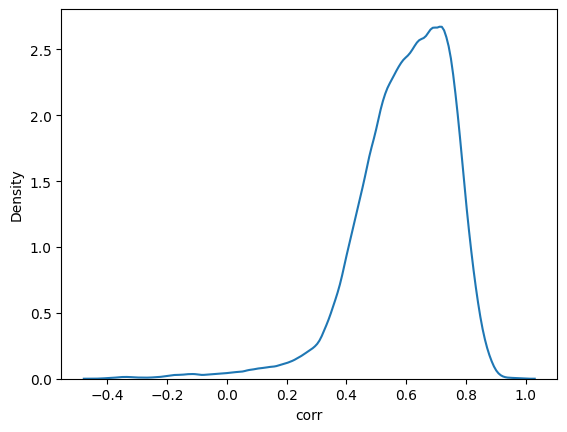

In [15]:
# View stacked_pcc_df as a hist

sns.kdeplot(stacked_pcc_df['corr'])
plt.show()

In [19]:
# Filter the stacked PCC DataFrame based on correlation value only
# Since there is no 'pval' column, we will filter based on the 'corr' column.
filtered_pcc_df = stacked_pcc_df[stacked_pcc_df["corr"] > 0.7]

# Optional: Apply Fisher's transformation to PCC values
# filtered_pcc_df['corr'] = filtered_pcc_df['corr'].apply(lambda r: 0.5 * np.log((1 + r) / (1 - r)))

# Isolate only the columns relevant for graphing: 'seq1', 'seq2', and 'corr'
filtered_pcc_slim = filtered_pcc_df[["seq1", "seq2", "corr"]]

filtered_pcc_slim

,seq1,seq2,corr
3,URS0000C1639A,URS000286A2F0,0.797865
4,URS0000C1639A,URS000268AA2E,0.734086
6,URS0000C1639A,URS0002905E51,0.777207
8,URS0000C1639A,URS000064AE72,0.705886
9,URS0000C1639A,URS0000B0F9C4,0.782259
...,...,...,...
998983,URS000094FF20,URS00026A7DD3,0.735328
998986,URS000094FF20,URS00006B323E,0.756198
998987,URS000094FF20,URS0000C883A9,0.703394
998990,URS000094FF20,URS00004FE0F7,0.722543


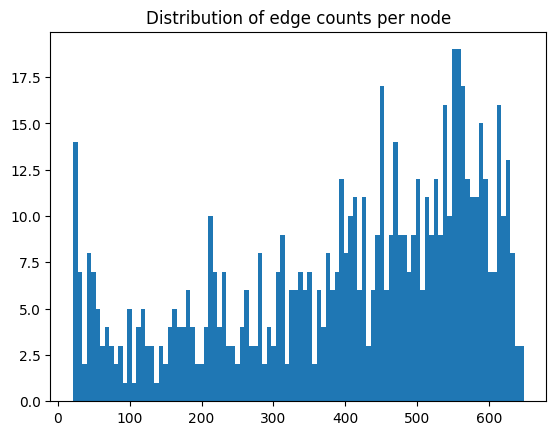

Number of nodes in the graph: 805
Number of edges in the graph: 140435


In [22]:
# Remove nodes with fewer than N edges
filtered_pcc_slim = rm_nodes_below_minimum_edge_count(filtered_pcc_df, min_edges=20, show_distribution=True)

# Build a graph from the filtered DataFrame
G_fm = build_graph(filtered_pcc_slim, source_node_idx=0, target_node_idx=1, edge_weight_idx=2)

# Display the number of nodes in the resulting graph
print(f"Number of nodes in the graph: {len(G_fm.nodes())}")
print(f"Number of edges in the graph: {len(G_fm.edges())}")

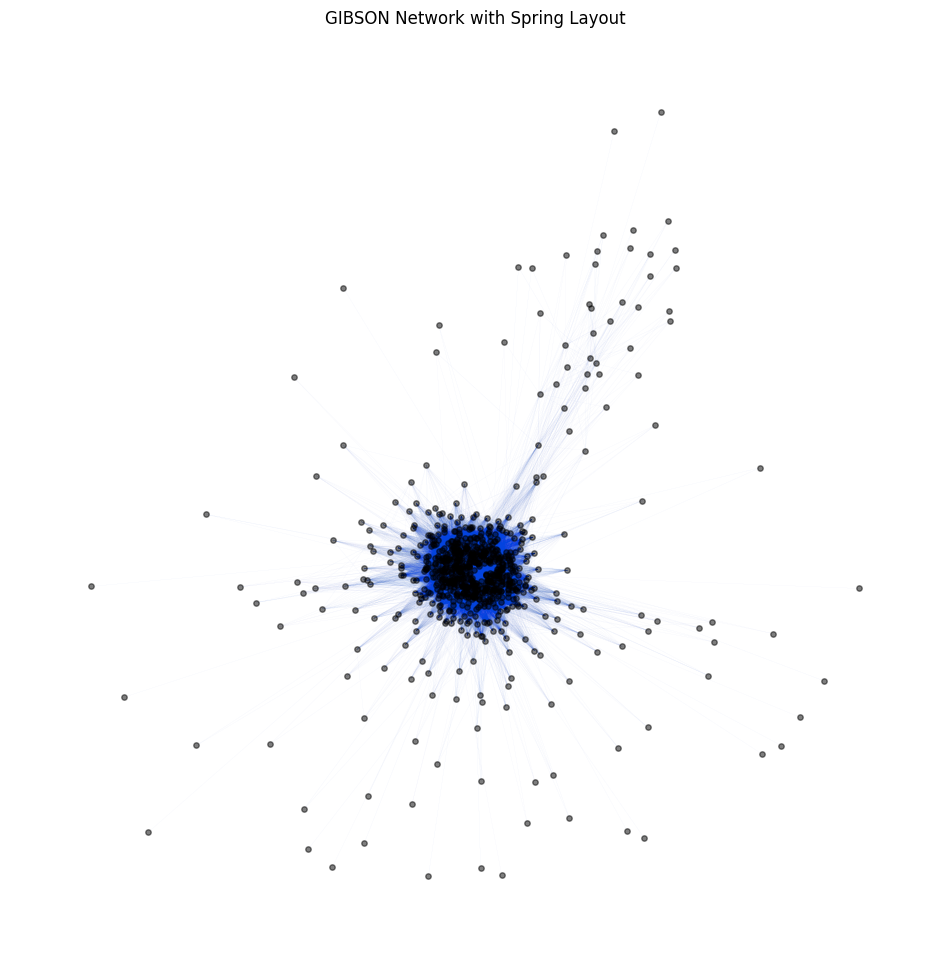

In [26]:
import random
import matplotlib.pyplot as plt
import networkx as nx

# Function to generate initial circular positions for nodes
def generate_circle_pos(G):
    """Generate a circular layout for the initial node positions."""
    return nx.circular_layout(G)

# Adjust position coordinates for better visualization (optional)
def adjust_position_coords(pos, invert_x=False, invert_y=False, rotate=False, rotate_angle=0):
    import math
    adjusted_pos = {}
    for node, (x, y) in pos.items():
        if invert_x:
            x = -x
        if invert_y:
            y = -y
        if rotate:
            angle_rad = math.radians(rotate_angle)
            x_rot = x * math.cos(angle_rad) - y * math.sin(angle_rad)
            y_rot = x * math.sin(angle_rad) + y * math.cos(angle_rad)
            x, y = x_rot, y_rot
        adjusted_pos[node] = (x, y)
    return adjusted_pos

# Assuming `filtered_pcc_slim` DataFrame is already defined with columns ['seq1', 'seq2', 'corr']
# Build the graph using the filtered PCC DataFrame
G_fm = build_graph(filtered_pcc_slim, source_node_idx=0, target_node_idx=1, edge_weight_idx=2)

# Generate initial positions using a circle layout (dictionary of positions)
initial_pos = generate_circle_pos(G_fm)

# Generate positions using the spring layout algorithm
random.seed(183)  # Set seed for reproducibility
positions_fm = nx.spring_layout(G_fm, pos=initial_pos, weight='weight', seed=183)  # Use spring layout

# Optional: Adjust position coordinates (e.g., invert x/y or rotate)
positions_fm_adjusted = adjust_position_coords(positions_fm, invert_x=True, invert_y=True, rotate=True, rotate_angle=55)

# Plot the final graph using adjusted positions
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G_fm, positions_fm_adjusted, node_size=15, node_color="xkcd:black", alpha=0.5)
nx.draw_networkx_edges(G_fm, positions_fm_adjusted, width=0.01, edge_color="xkcd:blue")
plt.axis("off")
plt.title("GIBSON Network with Spring Layout")
plt.show()


In [31]:
import json
import os
import networkx as nx

# Prepare Graph for Cytoscape Export
# Cytoscape provides better visualizations, especially for circular-like layouts.

# 1. Build a new graph `G_cyto` using the adjusted positions from the spring layout
G_cyto = nx.Graph()
G_cyto.add_nodes_from(positions_fm_adjusted.keys())  # Add nodes based on positions

# 2. Sort edges by correlation values in descending order (optional)
sorted_edges = sorted(
    [(source, target, G_fm[source][target]["weight"]) for source, target in G_fm.edges()],
    key=lambda x: x[2],  # Sort by weight (correlation value)
    reverse=True,
)

# 3. Add sorted edges to the new graph `G_cyto`
G_cyto.add_weighted_edges_from(sorted_edges)

# 4. Convert the NetworkX graph to Cytoscape-compatible data
cytoscape_data = nx.cytoscape_data(G_cyto)

# 5. Create the directory if it doesn't exist
output_dir = "data/json/cytoscape"
os.makedirs(output_dir, exist_ok=True)  # Create directory if not existing

# 6. Define a meaningful file name for the export
file_name = "spring_embedded_pcc_network_seq_len_100.json"
output_path = os.path.join(output_dir, file_name)

# 7. Write the Cytoscape data to a JSON file
with open(output_path, 'w') as json_file:
    json.dump(cytoscape_data, json_file, indent=4)

print(f"Graph exported to {output_path} for import into Cytoscape.")


Graph exported to data/json/cytoscape/spring_embedded_pcc_network_seq_len_100.json for import into Cytoscape.
